# 초기 준비

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

최대 성능의 모델을 구하기 위해 early stopping 컬백을 만들어 둔다

In [2]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

matplot 관련

그림 크기를 설정하고, 이후 사용할 color값을 구해 놓는다

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# 데이터 준비

In [4]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 불균형 비

In [5]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print("pos =", pos)
print("neg =", neg)
print("pos ratio =", pos / (pos+neg) * 100)

pos = 492
neg = 284315
pos ratio = 0.1727485630620034


## 데이터 분리

In [6]:
all_x = np.array(raw_df.loc[:, raw_df.columns!='Class'])
all_y = np.array(raw_df.loc[:, raw_df.columns=='Class']).squeeze()

indices = np.arange(all_x.shape[0])
np.random.shuffle(indices)
all_x = all_x[indices]
all_y = all_y[indices]

train_x, test_x, train_y, test_y = train_test_split(all_x, all_y, test_size=0.2)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(227845, 30)
(227845,)
(56962, 30)
(56962,)


## Standardization

평균 0, 표준편차 1로 stradardization 실행

In [7]:
scaler = StandardScaler()
scaler.fit(all_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

# 기본 모델

## 모델 생성

In [8]:
base_model = Sequential()
base_model.add(Dense(16, activation='relu', input_shape=(train_x.shape[-1],)))
base_model.add(Dropout(0.5))
base_model.add(Dense(1, activation="sigmoid"))

base_model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['acc', 'AUC'])

## 학습

In [9]:
base_line_history = base_model.fit(train_x, train_y, epochs=30, 
                              batch_size=1024, 
                              validation_split=0.2,
                              callbacks=[early_stopping])

Epoch 1/30
179/179 [==============================] - 2s 7ms/step - loss: 0.3038 - acc: 0.9069 - auc: 0.3826 - val_loss: 0.0770 - val_acc: 0.9986 - val_auc: 0.6088
Epoch 2/30
179/179 [==============================] - 1s 6ms/step - loss: 0.0990 - acc: 0.9916 - auc: 0.7140 - val_loss: 0.0207 - val_acc: 0.9989 - val_auc: 0.8136
Epoch 3/30
179/179 [==============================] - 1s 5ms/step - loss: 0.0538 - acc: 0.9970 - auc: 0.8276 - val_loss: 0.0092 - val_acc: 0.9992 - val_auc: 0.8813
Epoch 4/30
179/179 [==============================] - 1s 6ms/step - loss: 0.0377 - acc: 0.9983 - auc: 0.8670 - val_loss: 0.0058 - val_acc: 0.9992 - val_auc: 0.9041
Epoch 5/30
179/179 [==============================] - 1s 6ms/step - loss: 0.0293 - acc: 0.9987 - auc: 0.8787 - val_loss: 0.0044 - val_acc: 0.9993 - val_auc: 0.9183
Epoch 6/30
179/179 [==============================] - 1s 7ms/step - loss: 0.0242 - acc: 0.9989 - auc: 0.8783 - val_loss: 0.0036 - val_acc: 0.9993 - val_auc: 0.9268
Epoch 7/30
179/1

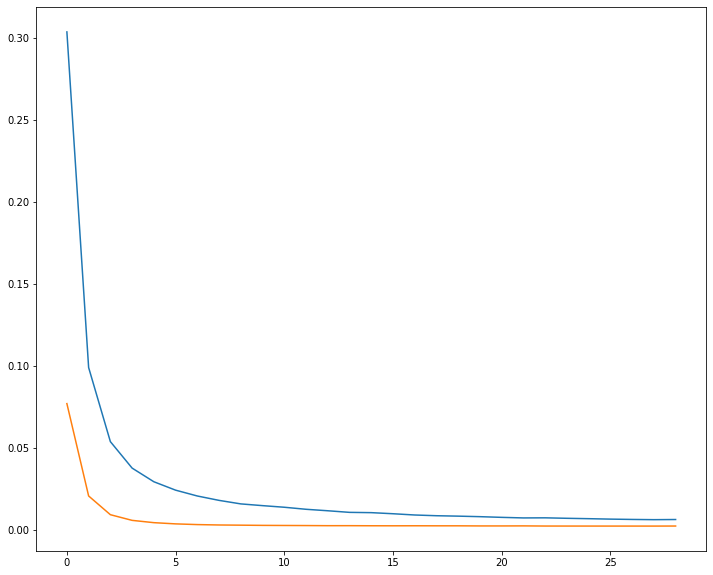

In [10]:
plt.plot(base_line_history.history['loss'])
plt.plot(base_line_history.history['val_loss'])
plt.show()

# 클래스 가중치 적용

## 가중치 계산


계산된 class_weight는 아래와 같이 계산된 값과 같다.
```
total = (pos + neg)
weight_for_0 = (1 / neg) * total/2
weight_for_1 = (1 / pos) * total/2
```

In [11]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight="balanced" , 
                     classes=np.unique(all_y), 
                     y=all_y.squeeze())
print(class_weight)

[  0.50086524 289.43800813]


In [12]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


## 모델 생성

In [13]:
weighted_model = Sequential()
weighted_model.add(Dense(16, activation='relu', input_shape=(train_x.shape[-1],)))
weighted_model.add(Dropout(0.5))
weighted_model.add(Dense(1, activation="sigmoid"))

weighted_model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['acc', 'AUC'])

## 학습

In [14]:
class_weighted_history = weighted_model.fit(train_x, train_y, epochs=30, 
                              batch_size=1024, 
                              validation_split=0.2,
                              callbacks=[early_stopping])

Epoch 1/30
179/179 [==============================] - 2s 7ms/step - loss: 0.3807 - acc: 0.8532 - auc: 0.2795 - val_loss: 0.1245 - val_acc: 0.9980 - val_auc: 0.1271
Epoch 2/30
179/179 [==============================] - 1s 6ms/step - loss: 0.1464 - acc: 0.9854 - auc: 0.5123 - val_loss: 0.0375 - val_acc: 0.9986 - val_auc: 0.7605
Epoch 3/30
179/179 [==============================] - 1s 6ms/step - loss: 0.0840 - acc: 0.9971 - auc: 0.7520 - val_loss: 0.0165 - val_acc: 0.9989 - val_auc: 0.8869
Epoch 4/30
179/179 [==============================] - 1s 6ms/step - loss: 0.0597 - acc: 0.9984 - auc: 0.8387 - val_loss: 0.0094 - val_acc: 0.9990 - val_auc: 0.9272
Epoch 5/30
179/179 [==============================] - 1s 6ms/step - loss: 0.0457 - acc: 0.9988 - auc: 0.8647 - val_loss: 0.0063 - val_acc: 0.9991 - val_auc: 0.9351
Epoch 6/30
179/179 [==============================] - 1s 6ms/step - loss: 0.0357 - acc: 0.9989 - auc: 0.8692 - val_loss: 0.0048 - val_acc: 0.9991 - val_auc: 0.9295
Epoch 7/30
179/1

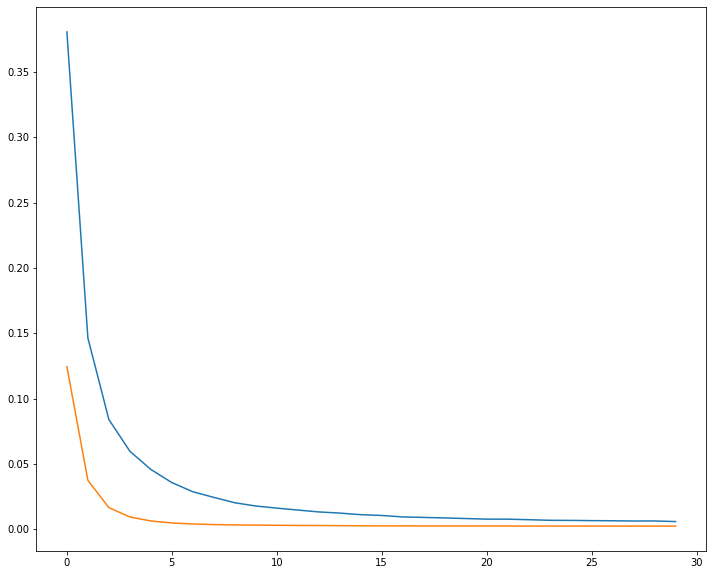

In [15]:
plt.plot(class_weighted_history.history['loss'])
plt.plot(class_weighted_history.history['val_loss'])
plt.show()

# 비교

In [16]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [17]:
train_predictions_baseline = base_model.predict(train_x, batch_size=1024)
test_predictions_baseline = base_model.predict(test_x, batch_size=1024)

In [18]:
train_predictions_weighted = weighted_model.predict(train_x, batch_size=1024)
test_predictions_weighted = weighted_model.predict(test_x, batch_size=1024)

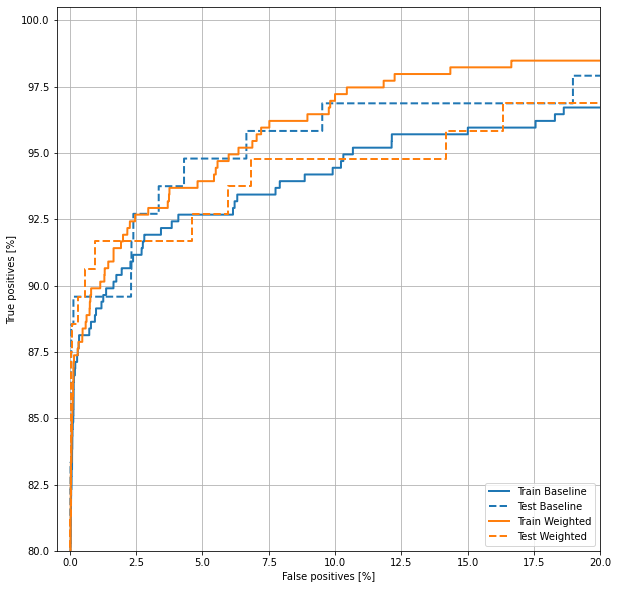

In [19]:
plot_roc("Train Baseline", train_y, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_y, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_y, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_y, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')
plt.show()

